### Convolutional Bi-Directional LSTM Stack

Reference Jon Krohn

In this notebook we classify 25000 movie reviews (binary) incorporating a number of concepts.

1. Vector space embedding
2. Convolution
3. Bi-directional LSTM



In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from keras.layers import Bidirectional
from keras.layers import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# vector-space embedding layer parameters
n_dim = 64
n_unique_words = 10000
max_review_length = 200
pad_type = trunc_type = 'pre'
drop_embed = 0.2

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)


17464789/17464789 [==============================] - 0s 0us/step


In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

Set Hyperparameters

In [5]:
# output directory name:
output_dir = 'weights_cnnLSTM'

# training:
epochs = 20
batch_size = 128

# convolutional layer architecture:
n_conv = 64
k_conv = 3 # filter size
mp_size = 4 # max pooling filter size

# LSTM layer architecture
n_lstm = 128
drop_lstm = 0.3

In [6]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(MaxPooling1D(mp_size))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 64)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 198, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 64)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 256)               197632    
 al)                                                             
                                                        

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [10]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/20
196/196 [==============================] - 46s 182ms/step - loss: 0.4633 - accuracy: 0.7556 - val_loss: 0.3255 - val_accuracy: 0.8588
Epoch 2/20
196/196 [==============================] - 18s 91ms/step - loss: 0.2342 - accuracy: 0.9082 - val_loss: 0.3040 - val_accuracy: 0.8708
Epoch 3/20
196/196 [==============================] - 12s 62ms/step - loss: 0.1740 - accuracy: 0.9368 - val_loss: 0.3385 - val_accuracy: 0.8624
Epoch 4/20
196/196 [==============================] - 10s 50ms/step - loss: 0.1285 - accuracy: 0.9553 - val_loss: 0.3608 - val_accuracy: 0.8580
Epoch 5/20
196/196 [==============================] - 6s 33ms/step - loss: 0.0993 - accuracy: 0.9676 - val_loss: 0.4463 - val_accuracy: 0.8543
Epoch 6/20
196/196 [==============================] - 6s 31ms/step - loss: 0.0714 - accuracy: 0.9774 - val_loss: 0.4327 - val_accuracy: 0.8512
Epoch 7/20
196/196 [==============================] - 5s 27ms/step - loss: 0.0540 - accuracy: 0.9837 - val_loss: 0.5421 - val_accuracy: 0

In [11]:
model.load_weights(output_dir+"/weights.07.keras") # zero-indexed

In [12]:
y_hat = model.predict(x_valid)


782/782 [==============================] - 4s 4ms/step


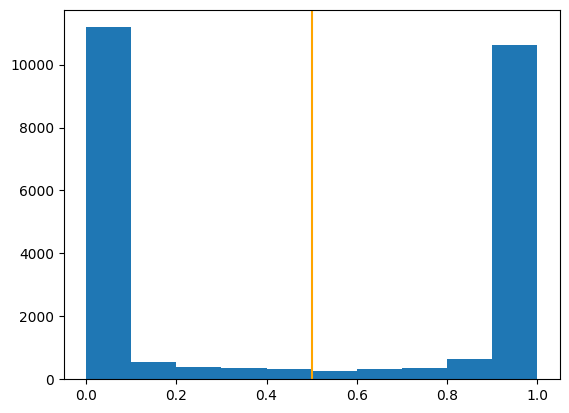

In [13]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)


'92.73'

This is pretty good performance but notice this model only takes 30ish seconds per epoch to train compared to much longer with the stacked bi-directional LSTM - this becomes an important trade off when data sets are very large.
